In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_backwards, plot_trading_strategy, download_stock_df, user_function, plot_candlestick
from utils import stock_trading_strategy_backwards

In [3]:
def plot_real_transaction(stock_name: str,
                          result: pd.DataFrame,
                          start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                          end=datetime.today().strftime('%Y-%m-%d'),
                          ):
    '''
    Input: stock_name, result
    Input result has columns ['date','action','executed_price','cash_flow']
    output: plot, result
    Output result has columns
    ['date','action','executed_price','cash_flow', 'close', 'num_shares_executed', 'total_cash', 'total_num_shares', 'total_stock_value', 'profit']
    '''
    df_stock = yf.download(stock_name.upper(), start=start, end=end)
    df_stock = df_stock.reset_index()
    df_stock.columns = df_stock.columns.str.lower()
    
    # sample plot using actual trading data
    plt.figure(figsize=(16, 8))
    plt.grid(True, alpha=0.5)
    
    plt.plot(df_stock['date'], df_stock['close'], label='Daily Close Price')
    
    # Shading the region between the highest and lowest prices
    plt.fill_between(df_stock['date'], df_stock['low'], df_stock['high'], color='gray', alpha=0.3, label='Daily Price Range')

    result['date'] = pd.to_datetime(result['date'])
    result = pd.merge(result,
                  df_stock[['date','close']],
                  on='date',
                  how='left')

    result['num_shares_executed'] = round(-1*result['cash_flow'] / result['executed_price'], 2)
    result['total_cash'] = result['cash_flow'].cumsum()
    result['total_num_shares'] = result['num_shares_executed'].cumsum()
    result['total_stock_value'] = result['total_num_shares']*result['close']
    result['profit'] = result['total_stock_value']+result['total_cash']
    result['profit%'] = -result['profit']/((result["action"]=="Purchase")*result['cash_flow']).cumsum()


    # plot the purchase actions as red dots
    purchases = result[result['action'] == 'Purchase']
    plt.scatter(purchases['date'], purchases['executed_price'], s=100, marker='^', color='green', label='Purchase')

    # plot the sell actions as blue dots
    sells = result[result['action'] == 'Sell']
    plt.scatter(sells['date'], sells['executed_price'], s=100, marker='v', color='red', label='Sell')

    for index, row in sells.iterrows():
        # plt.text(row['date'], row['executed_price'], row['executed_price'], ha='center', va='bottom')
        plt.annotate(f"{row['executed_price']:.2f}", xy=(row['date'], row['executed_price']), 
                     xytext=(row['date'], row['executed_price']*0.98), ha='center', va='top')
    for index, row in purchases.iterrows():
        # plt.text(row['date'], row['executed_price'], row['executed_price'], ha='center', va='bottom')
        plt.annotate(f"{row['executed_price']:.2f}", xy=(row['date'], row['executed_price']), 
                     xytext=(row['date'], row['executed_price']*0.98), ha='center', va='top')

    plt.xlabel('date')
    plt.ylabel('Stock Price')
    plt.title('Stock Trading Real Transaction - YINN')
    plt.legend()

    plt.show()

    return result

[*********************100%%**********************]  1 of 1 completed


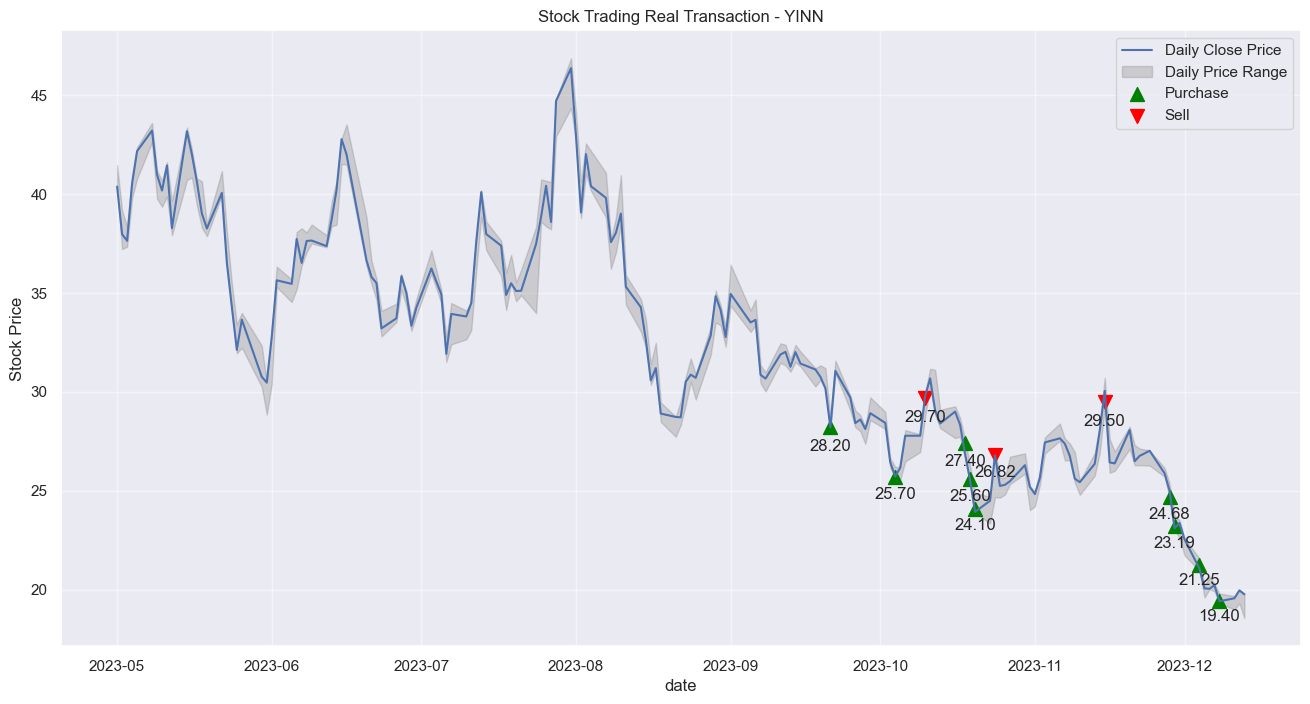

,date,action,executed_price,cash_flow,close,num_shares_executed,total_cash,total_num_shares,total_stock_value,profit,profit%
0,2023-09-21,Purchase,28.20,-1000.00,28.209999,35.46,-1000.00,35.46,1000.326568,0.326568,0.000327
1,2023-10-04,Purchase,25.70,-1000.00,25.719999,38.91,-2000.00,74.37,1912.796349,-87.203651,-0.043602
2,2023-10-10,Sell,29.70,1155.62,29.799999,-38.91,-844.38,35.46,1056.707973,212.327973,0.106164
3,2023-10-18,Purchase,27.40,-1000.00,26.870001,36.50,-1844.38,71.96,1933.565260,89.185260,0.029728
4,2023-10-19,Purchase,25.60,-2000.00,25.530001,78.12,-3844.38,150.08,3831.542503,-12.837497,-0.002567
5,2023-10-20,Purchase,24.10,-2000.00,23.930000,82.99,-5844.38,233.07,5577.365171,-267.014829,-0.038145
6,2023-10-24,Sell,26.82,2225.75,26.790001,-82.99,-3618.63,150.08,4020.643337,402.013337,0.057430
7,2023-11-15,Sell,29.50,2304.52,30.049999,-78.12,-1314.11,71.96,2162.397945,848.287945,0.121184
8,2023-11-28,Purchase,24.68,-2999.99,25.000000,121.56,-4314.10,193.52,4838.000000,523.900000,0.052390
9,2023-11-29,Purchase,23.19,-2999.98,23.100000,129.37,-7314.08,322.89,7458.759123,144.679123,0.011129


In [4]:
result = pd.DataFrame({
    'date': [
        '2023-09-21',
        "2023-10-04",
        "2023-10-10",
        "2023-10-18",
        "2023-10-19",
        "2023-10-20",
        "2023-10-24",
        "2023-11-15",
        "2023-11-28",
        "2023-11-29",
        "2023-12-04",
        "2023-12-08",
    ],
    'action':[
        'Purchase',
        "Purchase",
        "Sell",
        "Purchase",
        "Purchase",
        "Purchase",
        "Sell",
        "Sell",
        "Purchase",
        "Purchase",
        "Purchase",
        "Purchase",
    ],
    'executed_price':[
        28.2,
        25.7,
        29.7,
        27.4,
        25.6,
        24.1,
        26.82,
        29.5,
        24.68,
        23.19,
        21.25,
        19.4,
    ],
    'cash_flow':[
        -1000,
        -1000,
        1155.62,
        -1000,
        -2000,
        -2000,
        2225.75,
        2304.52,
        -2999.99,
        -2999.98,
        -2999.99,
        -3000
    ],
})
plot_real_transaction('yinn', result, start='2023-05-01')